##Load Detectron Libraries

In [2]:
import os
import io
import fvcore

# import some common libraries
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# import some common libraries
import numpy as np
import cv2
import torch

# Show the image in ipynb
from IPython.display import clear_output, Image, display
import PIL.Image
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

##Load Objects and Attributes Labels

In [5]:
# Load VG Classes
data_path = 'data/genome/1600-400-20'

vg_classes = []
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        vg_classes.append(object.split(',')[0].lower().strip())

vg_attrs = []
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for object in f.readlines():
        vg_attrs.append(object.split(',')[0].lower().strip())


MetadataCatalog.get("vg").thing_classes = vg_classes
MetadataCatalog.get("vg").attr_classes = vg_attrs

##Load the Config Files

In [7]:
cfg = get_cfg()
cfg.merge_from_file("../configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml")
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 300
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.6
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
# VG Weight
cfg.MODEL.WEIGHTS = "http://nlp.cs.unc.edu/models/faster_rcnn_from_caffe_attr.pkl"

WARNING [06/02 16:58:28 d2.config.compat]: Config '../configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [8]:
predictor = DefaultPredictor(cfg)

Modifications for VG in ResNet Backbone (modeling/backbone/resnet.py):
	Using pad 0 in stem max_pool instead of pad 1.

Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/roi_heads.py):
	1. Change the stride of conv1 and shortcut in Res5.Block1 from 2 to 1.
	2. Modifying all conv2 with (padding: 1 --> 2) and (dilation: 1 --> 2).
	For more details, please check 'https://github.com/peteanderson80/bottom-up-attention/blob/master/models/vg/ResNet-101/faster_rcnn_end2end_final/test.prototxt'.

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401



##Inference on Single Image

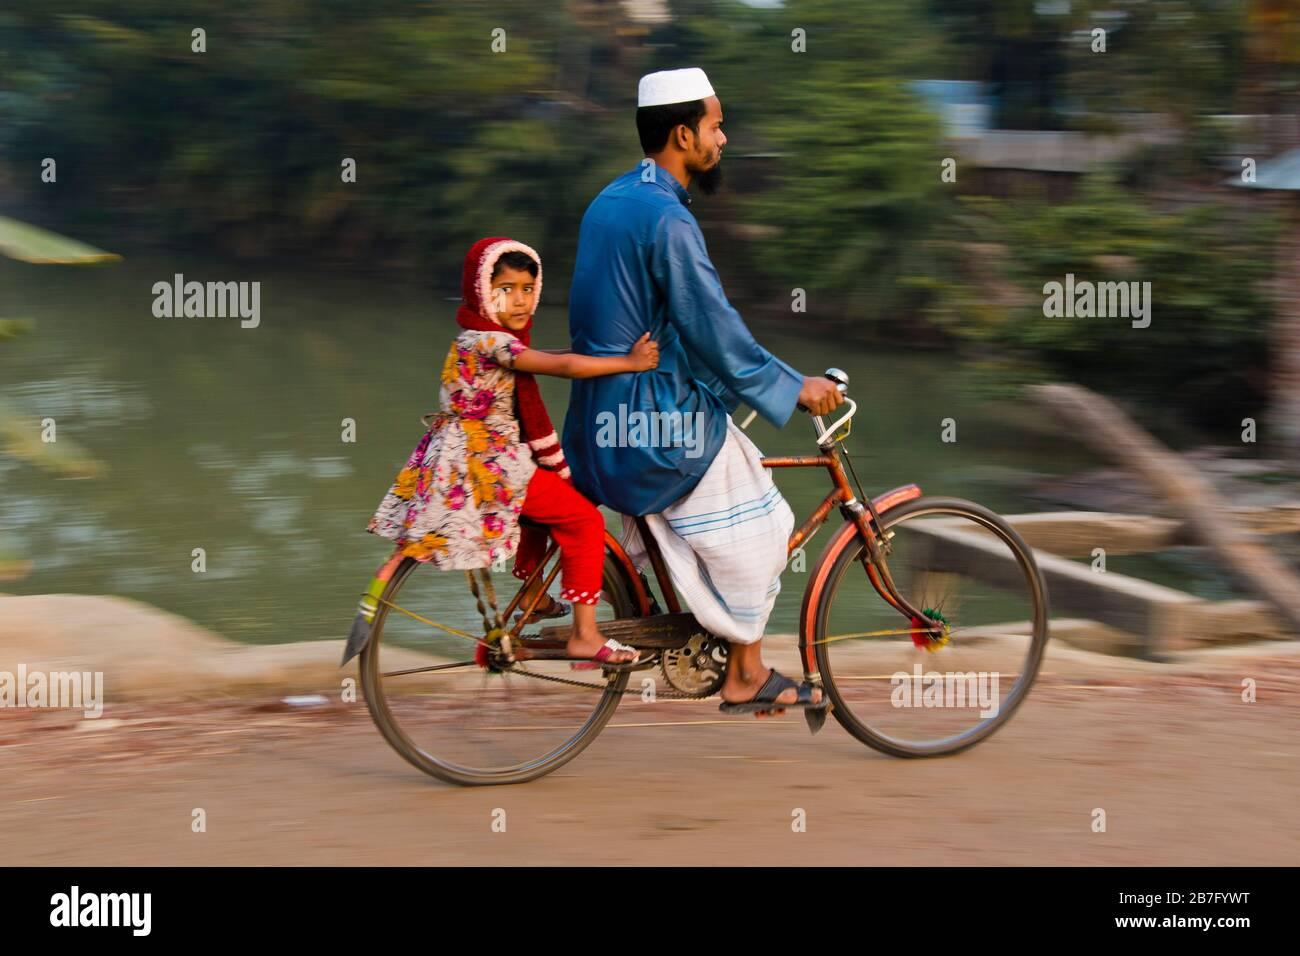

In [23]:
import cv2
# im = cv2.imread("data/images/COCO_val2014_000000509416.jpg")
im = cv2.imread("/content/a-group.jpg")
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
showarray(im_rgb)

In [17]:
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.14.0+cu117


In [ ]:
!pip install torchvision==0.18

In [24]:
NUM_OBJECTS = 10  # Segmented Objects

from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers, FastRCNNOutputs, fast_rcnn_inference_single_image

def doit(raw_image):
    with torch.no_grad():
        raw_height, raw_width = raw_image.shape[:2]
        print("Original image size: ", (raw_height, raw_width))

        # Preprocessing
        image = predictor.transform_gen.get_transform(raw_image).apply_image(raw_image)
        print("Transformed image size: ", image.shape[:2])
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        inputs = [{"image": image, "height": raw_height, "width": raw_width}]
        images = predictor.model.preprocess_image(inputs)

        # Run Backbone Res1-Res4
        features = predictor.model.backbone(images.tensor)

        # Generate proposals with RPN
        proposals, _ = predictor.model.proposal_generator(images, features, None)
        proposal = proposals[0]
        print('Proposal Boxes size:', proposal.proposal_boxes.tensor.shape)

        # Run RoI head for each proposal (RoI Pooling + Res5)
        proposal_boxes = [x.proposal_boxes for x in proposals]
        features = [features[f] for f in predictor.model.roi_heads.in_features]
        box_features = predictor.model.roi_heads._shared_roi_transform(
            features, proposal_boxes
        )
        feature_pooled = box_features.mean(dim=[2, 3])  # pooled to 1x1
        print('Pooled features size:', feature_pooled.shape)

        # Predict classes and boxes for each proposal.
        pred_class_logits, pred_attr_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(feature_pooled)
        outputs = FastRCNNOutputs(
            predictor.model.roi_heads.box2box_transform,
            pred_class_logits,
            pred_proposal_deltas,
            proposals,
            predictor.model.roi_heads.smooth_l1_beta,
        )
        probs = outputs.predict_probs()[0]
        boxes = outputs.predict_boxes()[0]

        attr_prob = pred_attr_logits[..., :-1].softmax(-1)
        max_attr_prob, max_attr_label = attr_prob.max(-1)

        # Note: BUTD uses raw RoI predictions,
        #       we use the predicted boxes instead.
        # boxes = proposal_boxes[0].tensor

        # NMS
        for nms_thresh in np.arange(0.5, 1.0, 0.1):
            instances, ids = fast_rcnn_inference_single_image(
                boxes, probs, image.shape[1:],
                score_thresh=0.2, nms_thresh=nms_thresh, topk_per_image=NUM_OBJECTS
            )
            if len(ids) == NUM_OBJECTS:
                break

        instances = detector_postprocess(instances, raw_height, raw_width)
        roi_features = feature_pooled[ids].detach()
        max_attr_prob = max_attr_prob[ids].detach()
        max_attr_label = max_attr_label[ids].detach()
        instances.attr_scores = max_attr_prob
        instances.attr_classes = max_attr_label

        print(instances)

        return instances, roi_features

instances, features = doit(im)



Original image size:  (956, 1300)
Transformed image size:  (800, 1088)
Proposal Boxes size: torch.Size([183, 4])
Pooled features size: torch.Size([183, 2048])
Instances(num_instances=10, image_height=956, image_width=1300, fields=[pred_boxes, scores, pred_classes, attr_scores, attr_classes])


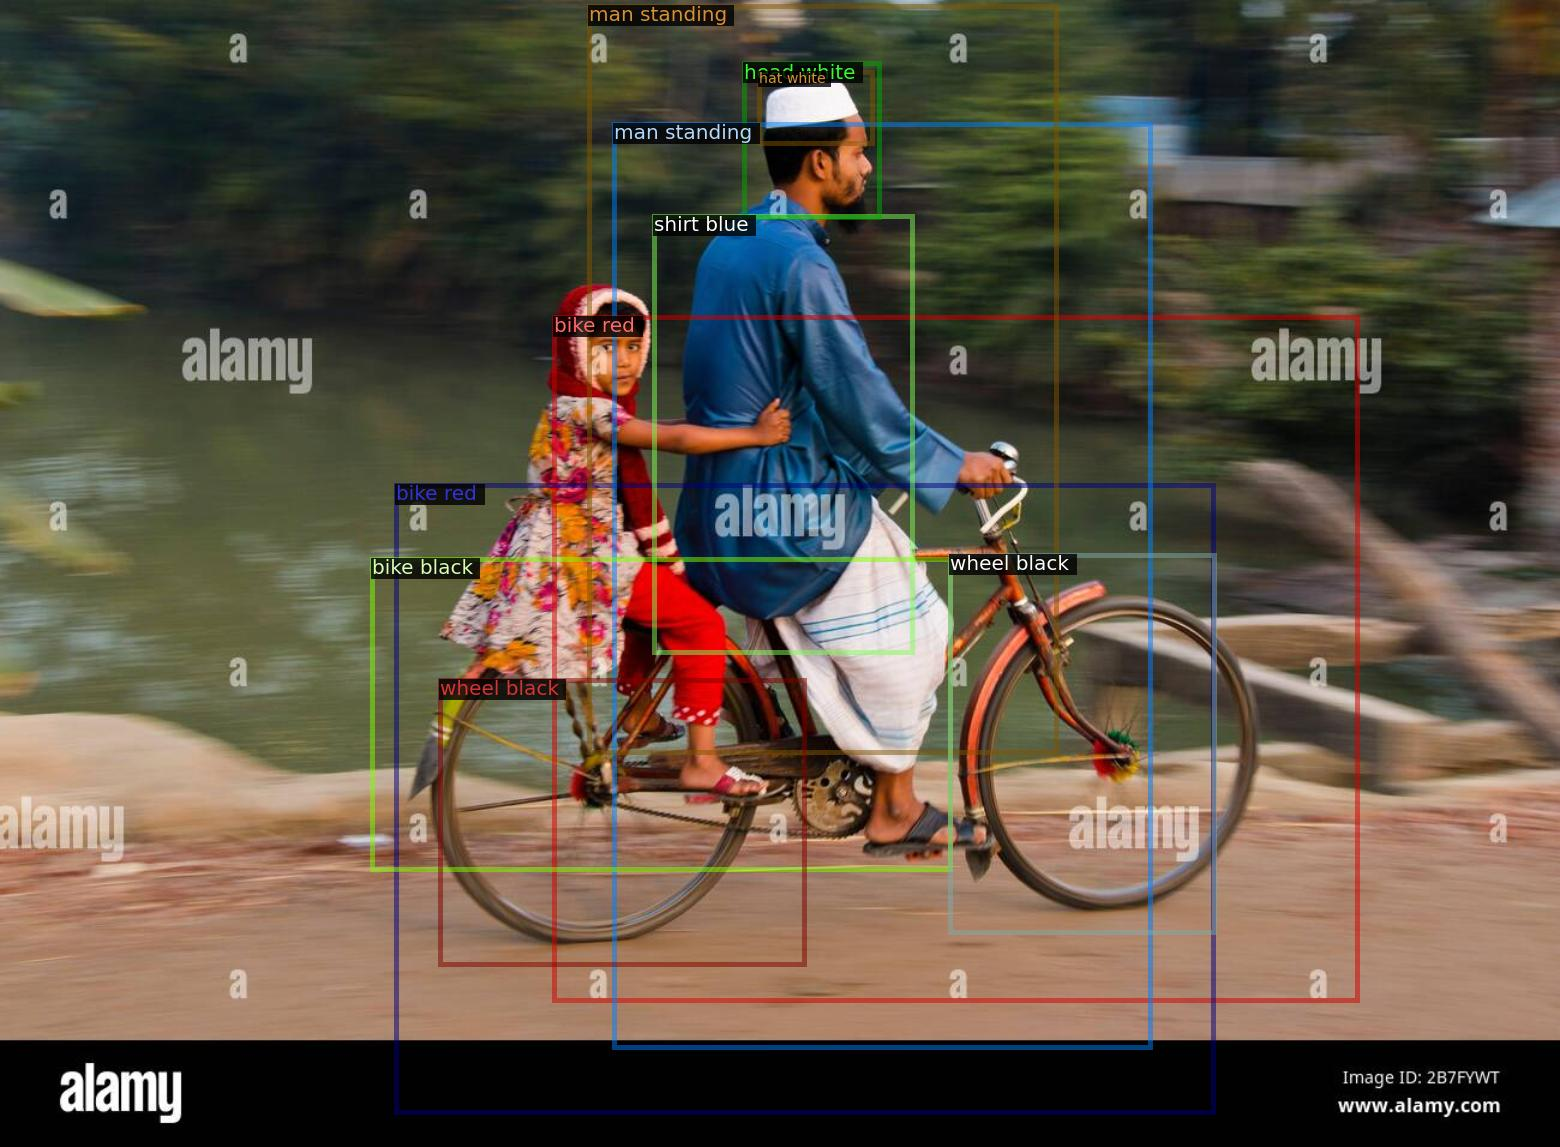

instances:
 Instances(num_instances=10, image_height=956, image_width=1300, fields=[pred_boxes, scores, pred_classes, attr_scores, attr_classes])

boxes:
 Boxes(tensor([[ 490.4738,    5.8929,  879.8792,  627.3544],
        [ 511.5920,  104.2102,  958.1235,  872.5132],
        [ 330.3795,  404.5182, 1011.0162,  926.5498],
        [ 545.1927,  181.1341,  760.1846,  543.5602],
        [ 461.9574,  264.8246, 1130.5764,  833.9877],
        [ 309.8468,  466.5566,  791.6367,  724.8156],
        [ 619.9221,   53.9384,  732.8732,  181.5647],
        [ 366.5729,  567.3879,  670.0901,  803.7498],
        [ 632.2500,   61.3169,  726.7291,  120.3085],
        [ 791.8167,  463.1983, 1011.8470,  777.0446]], device='cuda:0'))

Shape of features:
 torch.Size([10, 2048])


In [25]:
# Show the boxes, labels, and features
pred = instances.to('cpu')
v = Visualizer(im[:, :, :], MetadataCatalog.get("vg"), scale=1.2)
v = v.draw_instance_predictions(pred)
showarray(v.get_image()[:, :, ::-1])
print('instances:\n', instances)
print()
print('boxes:\n', instances.pred_boxes)
print()
print('Shape of features:\n', features.shape)

In [ ]:
l = pred.pred_classes.tolist()
a = pred.attr_classes.tolist()

In [ ]:
ob_att = dict()
for i in range(len(l)):
    key = vg_classes[l[i]]
    value = vg_attrs[a[i]]
    pair = (key, value)
    if pair not in ob_att.items():  # Check if the key-value pair is unique
        ob_att[key] = value


ob_att

{'helmet': 'blue',
 'shorts': 'blue',
 'boy': 'young',
 'trees': 'green',
 'tshirt': 'gray',
 'man': 'skateboarding'}

#MSCOCO Dataset

In [ ]:
import pandas as pd
from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
path = "/content/drive/MyDrive/Colab Notebooks/MS COCO Dataset/"
image_path = "/content/drive/MyDrive/Colab Notebooks/MS COCO Dataset/MSCOCO-Val-500/MSCOCO_500_Val/"

In [ ]:
data = pd.read_excel(path + 'MSCOCO_Objects.xlsx')
data.head()

##Run Inference on Faster RCNN

In [ ]:
from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers, FastRCNNOutputs, fast_rcnn_inference_single_image

NUM_OBJECTS = 15

def doit(raw_image):
    with torch.no_grad():
        raw_height, raw_width = raw_image.shape[:2]
        #print("Original image size: ", (raw_height, raw_width))

        # Preprocessing
        image = predictor.transform_gen.get_transform(raw_image).apply_image(raw_image)
        #print("Transformed image size: ", image.shape[:2])
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        inputs = [{"image": image, "height": raw_height, "width": raw_width}]
        images = predictor.model.preprocess_image(inputs)

        # Run Backbone Res1-Res4
        features = predictor.model.backbone(images.tensor)

        # Generate proposals with RPN
        proposals, _ = predictor.model.proposal_generator(images, features, None)
        proposal = proposals[0]
        #print('Proposal Boxes size:', proposal.proposal_boxes.tensor.shape)

        # Run RoI head for each proposal (RoI Pooling + Res5)
        proposal_boxes = [x.proposal_boxes for x in proposals]
        features = [features[f] for f in predictor.model.roi_heads.in_features]
        box_features = predictor.model.roi_heads._shared_roi_transform(
            features, proposal_boxes
        )
        feature_pooled = box_features.mean(dim=[2, 3])  # pooled to 1x1
        #print('Pooled features size:', feature_pooled.shape)

        # Predict classes and boxes for each proposal.
        pred_class_logits, pred_attr_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(feature_pooled)
        outputs = FastRCNNOutputs(
            predictor.model.roi_heads.box2box_transform,
            pred_class_logits,
            pred_proposal_deltas,
            proposals,
            predictor.model.roi_heads.smooth_l1_beta,
        )
        probs = outputs.predict_probs()[0]
        boxes = outputs.predict_boxes()[0]

        attr_prob = pred_attr_logits[..., :-1].softmax(-1)
        max_attr_prob, max_attr_label = attr_prob.max(-1)

        # Note: BUTD uses raw RoI predictions,
        #       we use the predicted boxes instead.
        # boxes = proposal_boxes[0].tensor

        # NMS
        for nms_thresh in np.arange(0.5, 1.0, 0.1):
            instances, ids = fast_rcnn_inference_single_image(
                boxes, probs, image.shape[1:],
                score_thresh=0.2, nms_thresh=nms_thresh, topk_per_image=NUM_OBJECTS
            )
            if len(ids) == NUM_OBJECTS:
                break

        instances = detector_postprocess(instances, raw_height, raw_width)
        roi_features = feature_pooled[ids].detach()
        max_attr_prob = max_attr_prob[ids].detach()
        max_attr_label = max_attr_label[ids].detach()
        instances.attr_scores = max_attr_prob
        instances.attr_classes = max_attr_label

        # print(instances)

        return instances, roi_features

In [ ]:
def detectron_output(image_path,image_names):

  ob_att_list = list()

  for i in tqdm(range(len(image_names)), desc = "Extracting Objects and Attributes: "):
    image_name = image_path+image_names[i]
    # print(i)
    im = cv2.imread(image_name)
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    instances, features = doit(im)
    pred = instances.to('cpu')
    l = pred.pred_classes.tolist()
    a = pred.attr_classes.tolist()

    ob_att = dict()
    for i in range(len(l)):
        key = vg_classes[l[i]]
        value = vg_attrs[a[i]]
        pair = (key, value)
        if pair not in ob_att.items():  # Check if the key-value pair is unique
            ob_att[key] = value

    ob_att_list.append(ob_att)

  return ob_att_list

outputs = detectron_output(image_path,data['image'].tolist())
outputs

In [ ]:
data['objects'] = outputs
data = data[["image_id",	"image",	"objects",	"relations"]]
data.to_excel(path+ "MSCOCO_image_Relations.xlsx", index=False)